In [14]:
from copy import deepcopy
import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120

figures_dir = "/Users/matsen/writing/talks/figures/bcr-mut-sel/"
# if this path does not exist, set it to ""
if not os.path.exists(figures_dir):
    figures_dir = ""

# default_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': default_font_size * 1.4})

In [22]:
# compare_df = pd.read_csv("../train/_ignore/mouse_model_compare.csv")
compare_df = pd.read_csv("../train/_ignore/human_model_compare.csv")

# drop rows where crepe_basename is s5f and put them in a separate df called literature_df
literature_models = ["s5f"]
literature_df = compare_df[compare_df["crepe_basename"].isin(literature_models)]
compare_df = compare_df[~compare_df["crepe_basename"].isin(literature_models)]

# split crepe_basename on "-", the first entry is the model name and the second entry is the train dataset
compare_df["model"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[0])
compare_df["train dataset"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[1])
compare_df["training method"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[2])
compare_df["seed"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[3])
compare_df = compare_df.drop(columns=["crepe_prefix", "crepe_basename"])
compare_df = compare_df.rename(columns={"dataset_name": "test dataset"})
compare_df = compare_df.sort_values(by=["train dataset", "model"]).reset_index(drop=True)

compare_df["model"].unique()
compare_df

,parameter_count,test dataset,AUROC,AUPRC,r-prec,mut_pos_ll,sub_acc,base_ll,model,train dataset,training method,seed
0,2286,shmoof_small,0.817222,0.101922,0.049126,-0.056091,0.541502,-0.970331,cnn_hyb_sml,shmoof_small,fixed,0
1,2286,val_tangshm,0.836519,0.143834,0.097457,-0.097570,0.471922,-1.049296,cnn_hyb_sml,shmoof_small,fixed,0
2,2286,val_oracleshmoofcnn10k,0.817284,0.108519,0.060485,-0.065910,0.512655,-1.003501,cnn_hyb_sml,shmoof_small,fixed,0
3,2286,val_oracletangcnn,0.822507,0.132044,0.081655,-0.090190,0.517019,-1.002566,cnn_hyb_sml,shmoof_small,fixed,0
4,2286,shmoof_small,0.815933,0.101820,0.050520,-0.056349,0.535914,-0.964963,cnn_hyb_sml,shmoof_small,fixed,1
...,...,...,...,...,...,...,...,...,...,...,...,...
155,4600,val_oracletangcnn,0.819626,0.127136,0.075530,-0.091531,0.511193,-1.005393,rsshmoof,shmoof_small,fixed,3
156,4600,shmoof_small,0.816424,0.104390,0.053009,-0.056331,0.533733,-0.968219,rsshmoof,shmoof_small,fixed,4
157,4600,val_tangshm,0.831530,0.139103,0.089809,-0.099569,0.469728,-1.042815,rsshmoof,shmoof_small,fixed,4
158,4600,val_oracleshmoofcnn10k,0.815461,0.104862,0.059547,-0.066462,0.508875,-1.007528,rsshmoof,shmoof_small,fixed,4


In [57]:
df = compare_df.copy()

# drop any rows where model matches 4k or 8k
df = df[~df.model.str.contains("4k")]
df = df[~df.model.str.contains("8k")]

# For every row with rsshmoof as the model subtract off 4**5 from the parameter
# count, correspding to every possible 5mer getting mutated to itself. We handle
# this setting indirectly by zeroing out the WT prediction.
def fiddle_parameter_count(row):
    if row["model"] in ["rsshmoof", "origshmoof"]:
        # This corresponds to every 5mer being mutated to itself.
        return row["parameter_count"] - 4**5
    elif row["model"] in ["fivemer"]:
        # This corresponds to every 5mer being mutated to itself, and also 
        # the fact that for the parameterization we're using rates and
        # conditional probabilities, which are only used as a product 
        # so the effective number of parameters is less.
        return row["parameter_count"] - 2 * 4**5
    else:
        return row["parameter_count"]
df["parameter_count"] = df.apply(fiddle_parameter_count, axis=1)

# Dictionaries for translation
model_translations = {
    "fivemer": "5mer",
    "rsshmoof": "Spisak",
    "cnn": "CNN",
    "ind": "Indep",
    "joi": "Joined",
    "hyb": "Hybrid",
    "sml": "Small",
    "med": "Medium",
    "lrg": "Large",
    "4k": "4K"
}

def create_long_name(row):
    parts = row["model"].split('_')
    # Translate each part using the model_translations dictionary
    full_name_parts = [model_translations.get(part, part) for part in parts]
    # Special handling for models without underscores
    if len(full_name_parts) == 1:
        full_name = model_translations.get(row["model"], row["model"])
    else:
        # Join the translated parts with spaces for CNN models
        full_name = ' '.join(full_name_parts[:-1]) + " " + full_name_parts[-1]
    return f"{full_name} ({row['parameter_count']})"
    #return f"{full_name} ({row['parameter_count']}) {row['training method']}"

# Apply the transformation to create the long_name column
df['long_name'] = df.apply(create_long_name, axis=1)

# sort df by parameter count
df = df.sort_values(by="parameter_count", kind="mergesort")
# reverse stable sort by test dataset   
df = df.sort_values(by="test dataset", kind="mergesort")

# extract the rows where "test dataset" is "val_oracleshmoofcnn10k" and put them in a separate df called oracle_df
for (oracle_data, oracle_data_nickname) in [("val_oracleshmoofcnn10k", "shmoof_small"), ("val_oracletangcnn", "val_tangshm")]:
    oracle_df = df[df["test dataset"] == oracle_data]
    df = df[df["test dataset"] != oracle_data]

    # drop all rows where model isn't cnn_joi_lrg
    oracle_df = oracle_df[oracle_df["model"] == "cnn_joi_lrg"]
    oracle_df["test dataset"] = oracle_data_nickname
    oracle_df["long_name"] = "Oracle"

    # append oracle_df to df
    df = pd.concat([df, oracle_df])

df["long_name"].unique(), df["model"].unique()

(array(['CNN Joined Small (1082)', 'CNN Joined Medium (1581)',
        'CNN Joined Large (2057)', 'CNN Hybrid Small (2286)',
        'CNN Indep Small (3066)', '5mer (3077)', 'Spisak (3576)', 'Oracle'],
       dtype=object),
 array(['cnn_joi_sml', 'cnn_joi_med', 'cnn_joi_lrg', 'cnn_hyb_sml',
        'cnn_ind_sml', 'fivemer', 'rsshmoof'], dtype=object))

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_45953/2411889758.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(df["seed"].unique()))
/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_45953/2411889758.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(df["seed"].unique()))


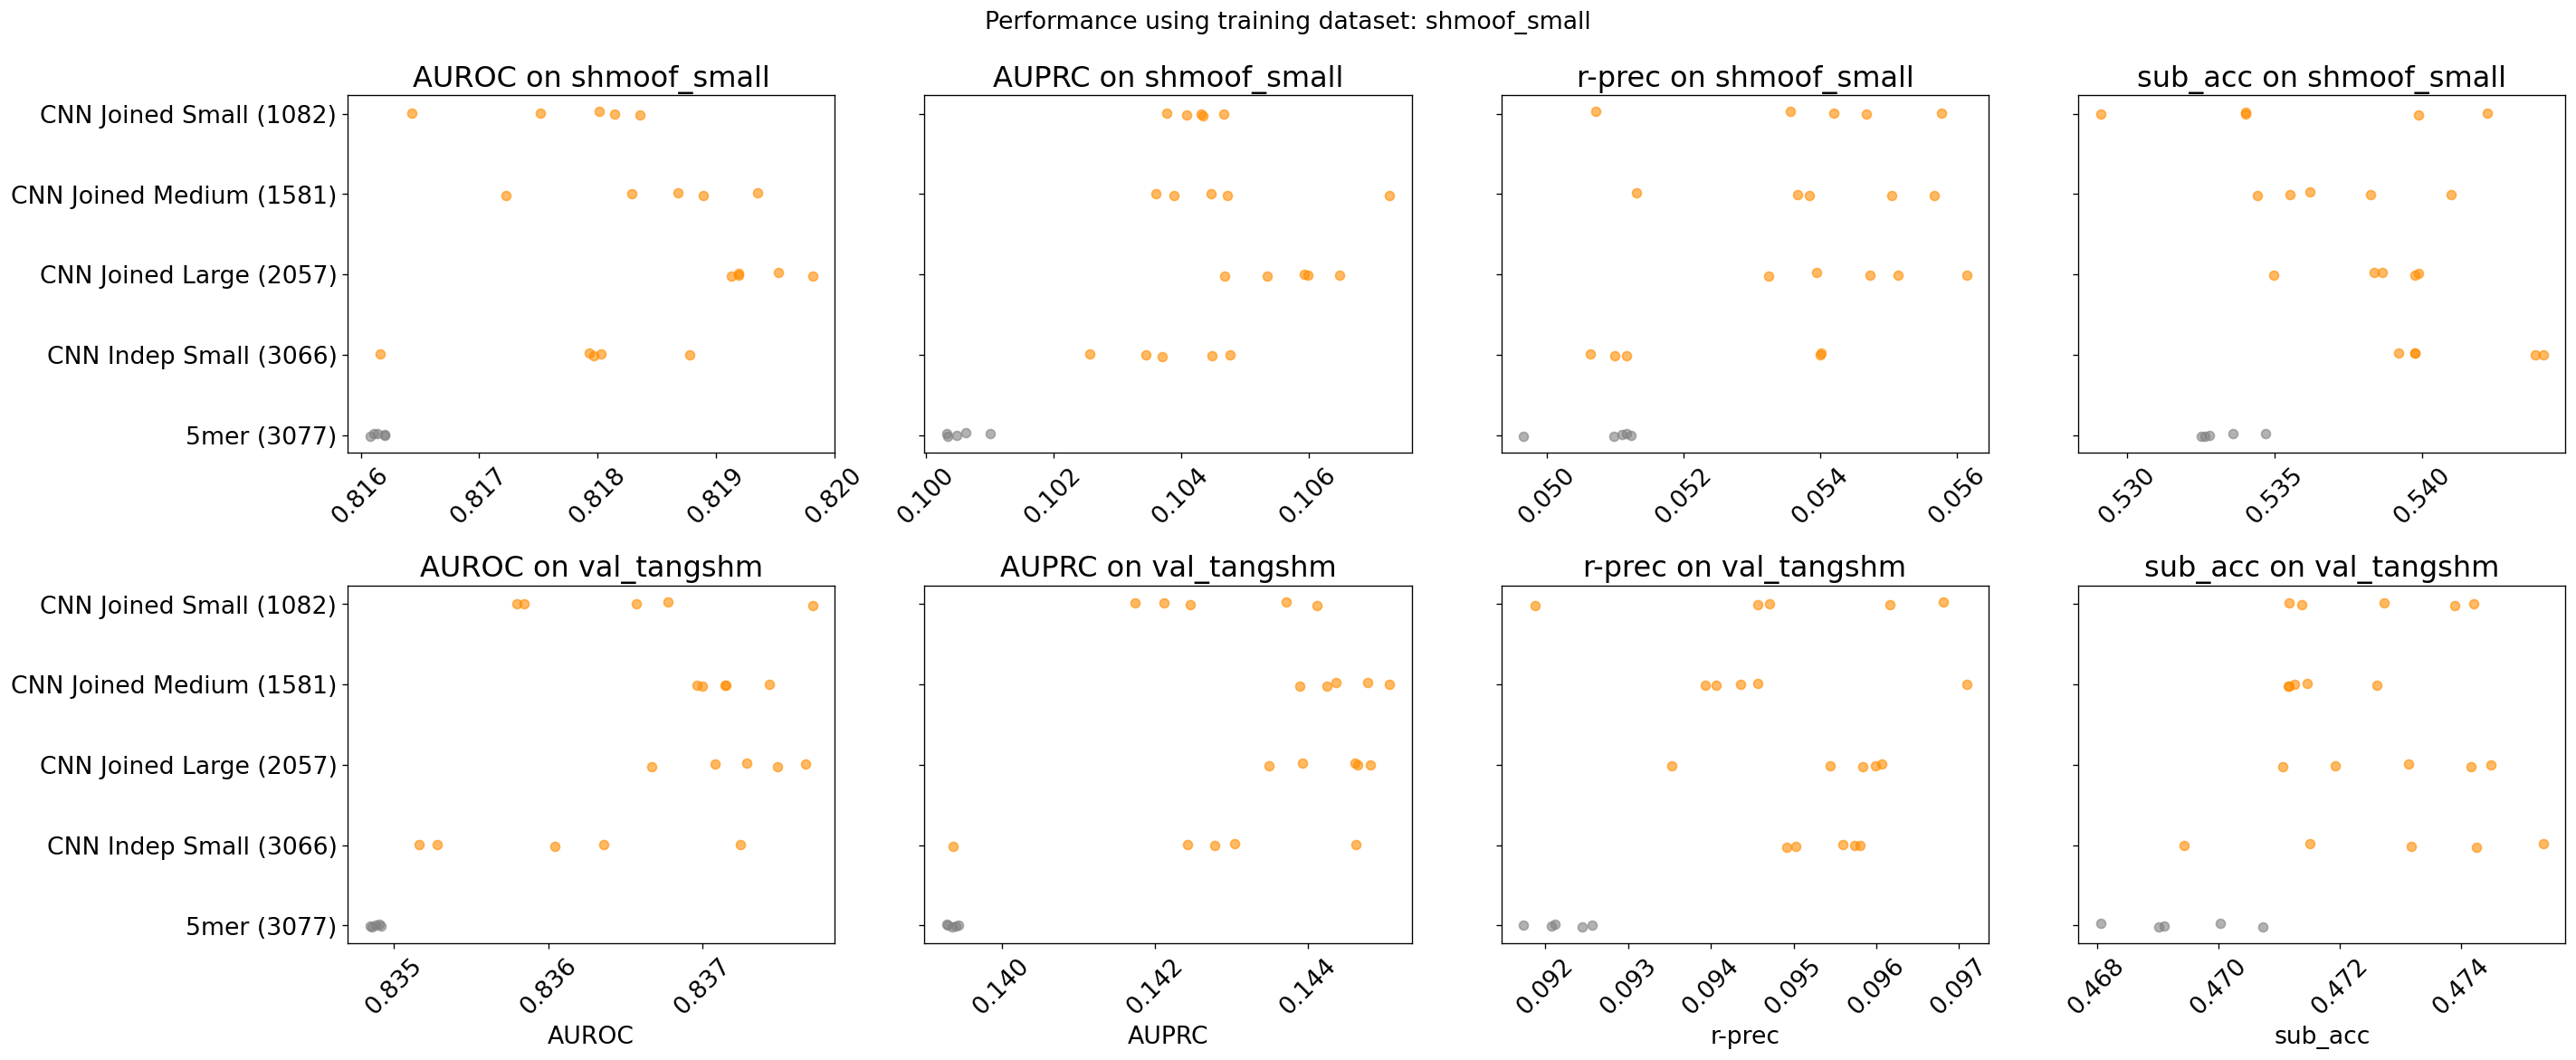

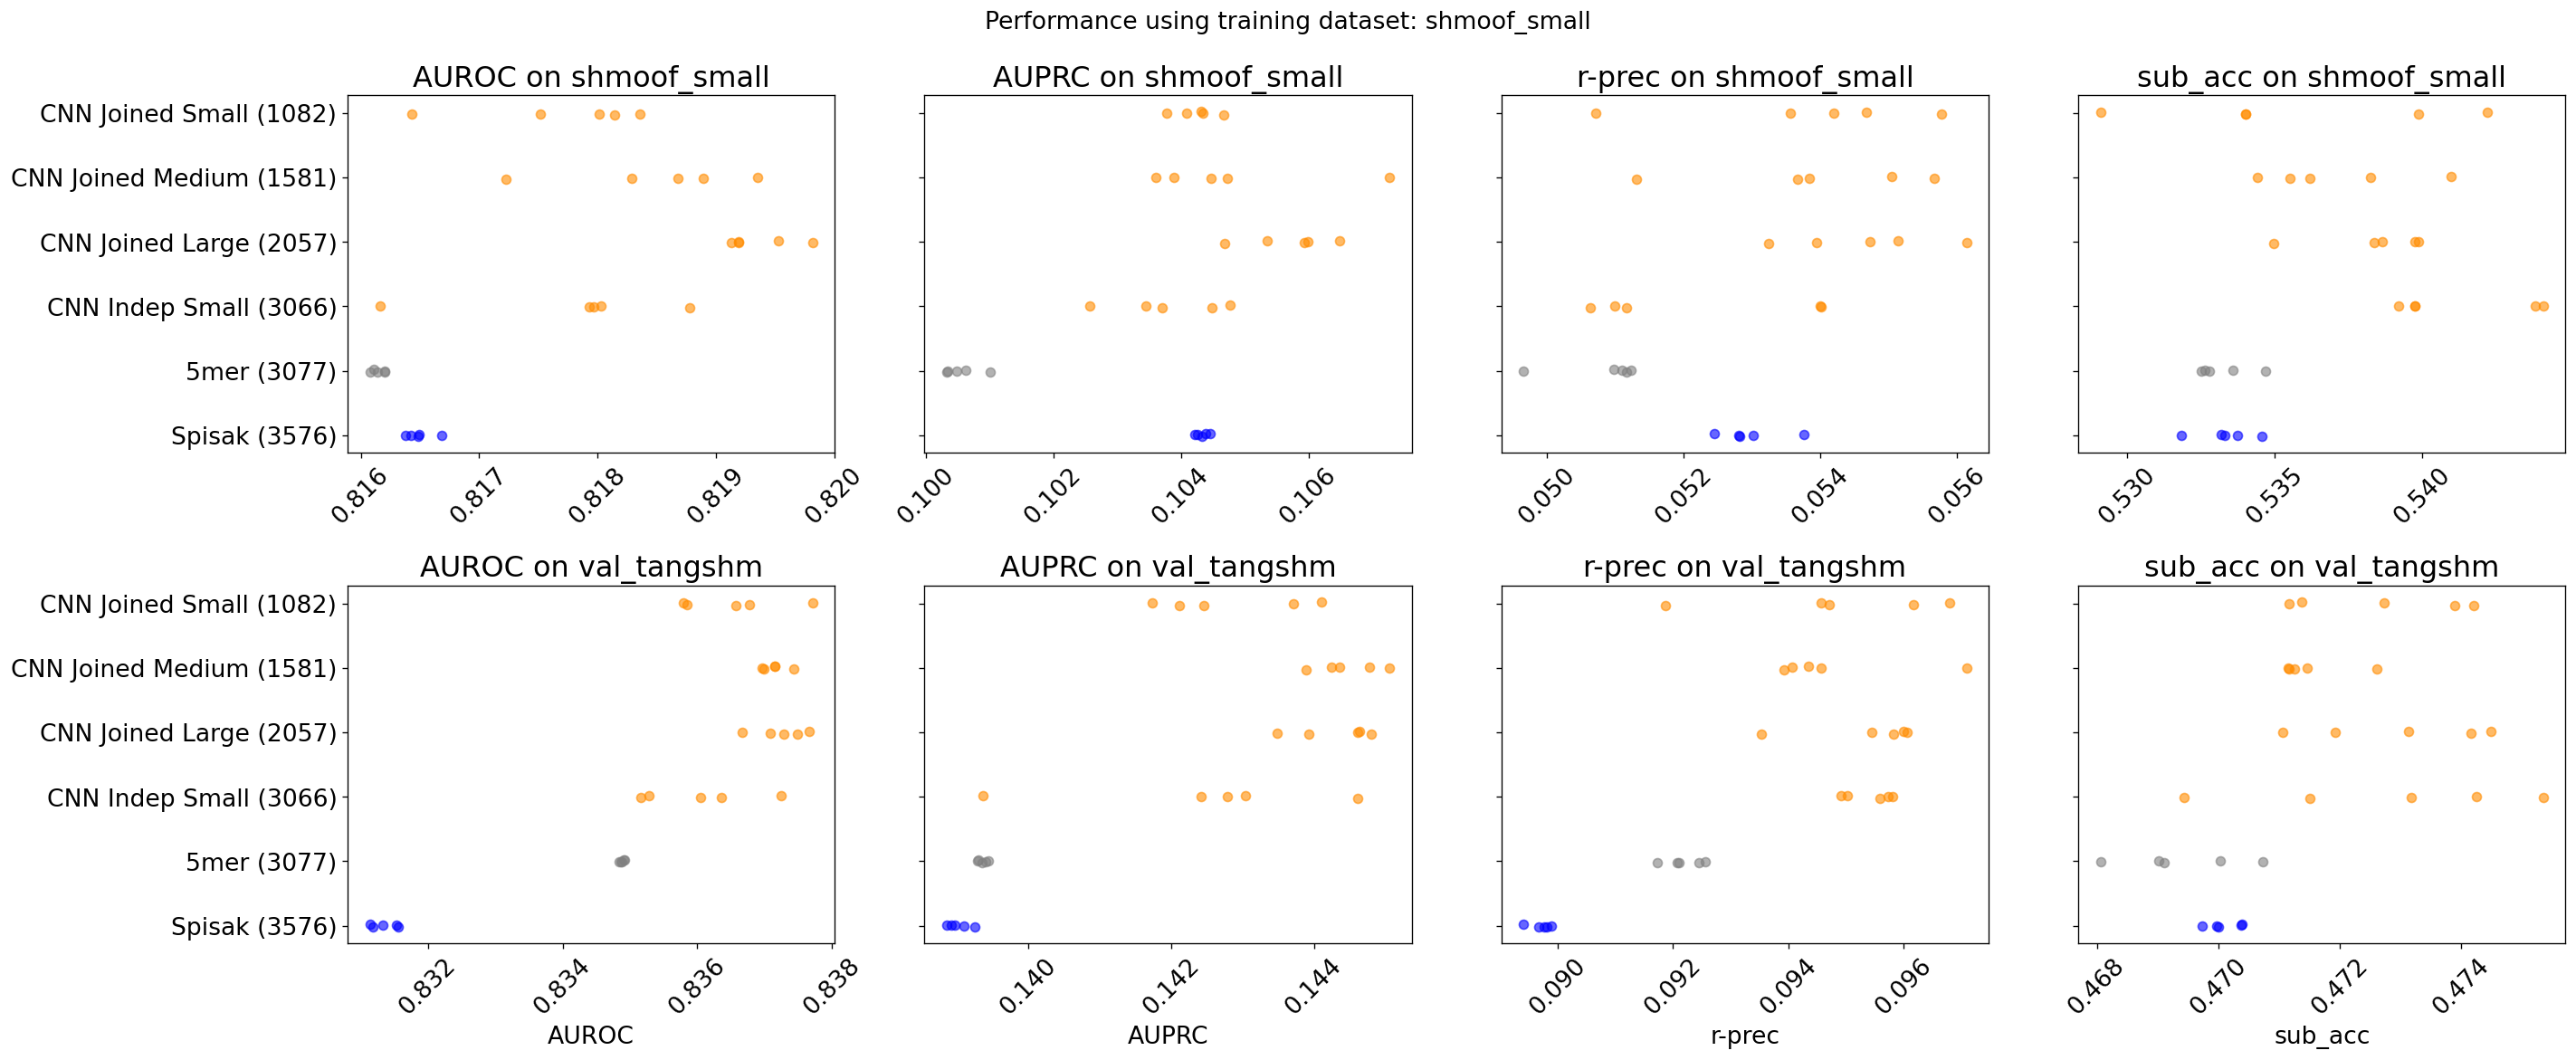

In [61]:
def plot_performance(df, include_shmoof, include_baseline, train_dataset = "shmoof_small"):
    df = df.copy()
    df = df[df["long_name"] != "Oracle"]
    df = df[df["model"] != "cnn_hyb_sml"]
    if not include_shmoof:
        df = df[df["model"] != "rsshmoof"]

    # Assuming df is your DataFrame
    stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc']
    train_datasets = df['train dataset'].unique()
    test_datasets = df['test dataset'].unique()
    unique_long_names = df['long_name'].unique()[::-1]
    name_to_y = {name: i for i, name in enumerate(unique_long_names)}

    # Setup figure parameters, transposing nrows with ncols
    nrows = len(test_datasets)
    ncols = len(stats)

    # make a colormap with a different color for each seed
    df["seed"] = df["seed"].astype(int)
    seed_count = len(df["seed"].unique())
    cmap = plt.cm.get_cmap('tab20', len(df["seed"].unique()))
                        
    # Define the jitter range for the y-values
    jitter_strength = 0.05  # Smaller for subtler jitter

    # Loop through each training dataset to create separate figures or subplot grids
    # for train_dataset in train_datasets:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False, sharey=True)
    # set font size for fig
    plt.rcParams.update({'font.size': 16})
    fig.suptitle(f'Performance using training dataset: {train_dataset}', fontsize=16)

    for row_idx, test_dataset in enumerate(test_datasets):
        # Filter the DataFrame for models trained on `train_dataset` and tested on `test_dataset`
        df_filtered = df[(df['train dataset'] == train_dataset) & (df['test dataset'] == test_dataset)].copy()

        baseline_values = literature_df[literature_df['dataset_name'] == test_dataset].iloc[0]
        for col_idx, stat in enumerate(stats):
            if not df_filtered.empty:
                df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
                df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

                ax = axes[row_idx, col_idx]

                # Plot each point, adding jitter around the assigned y-value
                for i, row in df_filtered.iterrows():
                    y_pos = name_to_y[row['long_name']] + (np.random.rand() - 0.5) * jitter_strength
                    # if row["model"] contains ("cnn"):
                    if row["model"][:3] == "cnn":
                        color = "darkorange"
                    elif row["model"] == "rsshmoof":
                        color = "blue"
                    else:
                        color = "gray"
                    ax.scatter(row[stat], y_pos, color=color, alpha=0.6)

                if include_baseline:
                    ax.axvline(x=baseline_values[stat], color='k')  # Vertical line at 0

                ax.set_yticks(np.arange(len(unique_long_names)))
                ax.set_yticklabels(unique_long_names)
                ax.set_title(f"{stat} on {test_dataset}")
                ax.tick_params(axis='x', rotation=45)
                if row_idx == nrows - 1:  # Only set x-labels for the bottom row
                    ax.set_xlabel(f'{stat}')
    fig.tight_layout()
    filename = "performance"
    if include_shmoof:
        filename += "_with_shmoof"
    if include_baseline:
        filename += "_with_baseline"
    fig.savefig(os.path.join(figures_dir, f"{filename}.svg"))

plot_performance(df, include_shmoof=False)
plot_performance(df, include_shmoof=True)
plot_performance(df, include_shmoof=True, include_baseline=True)


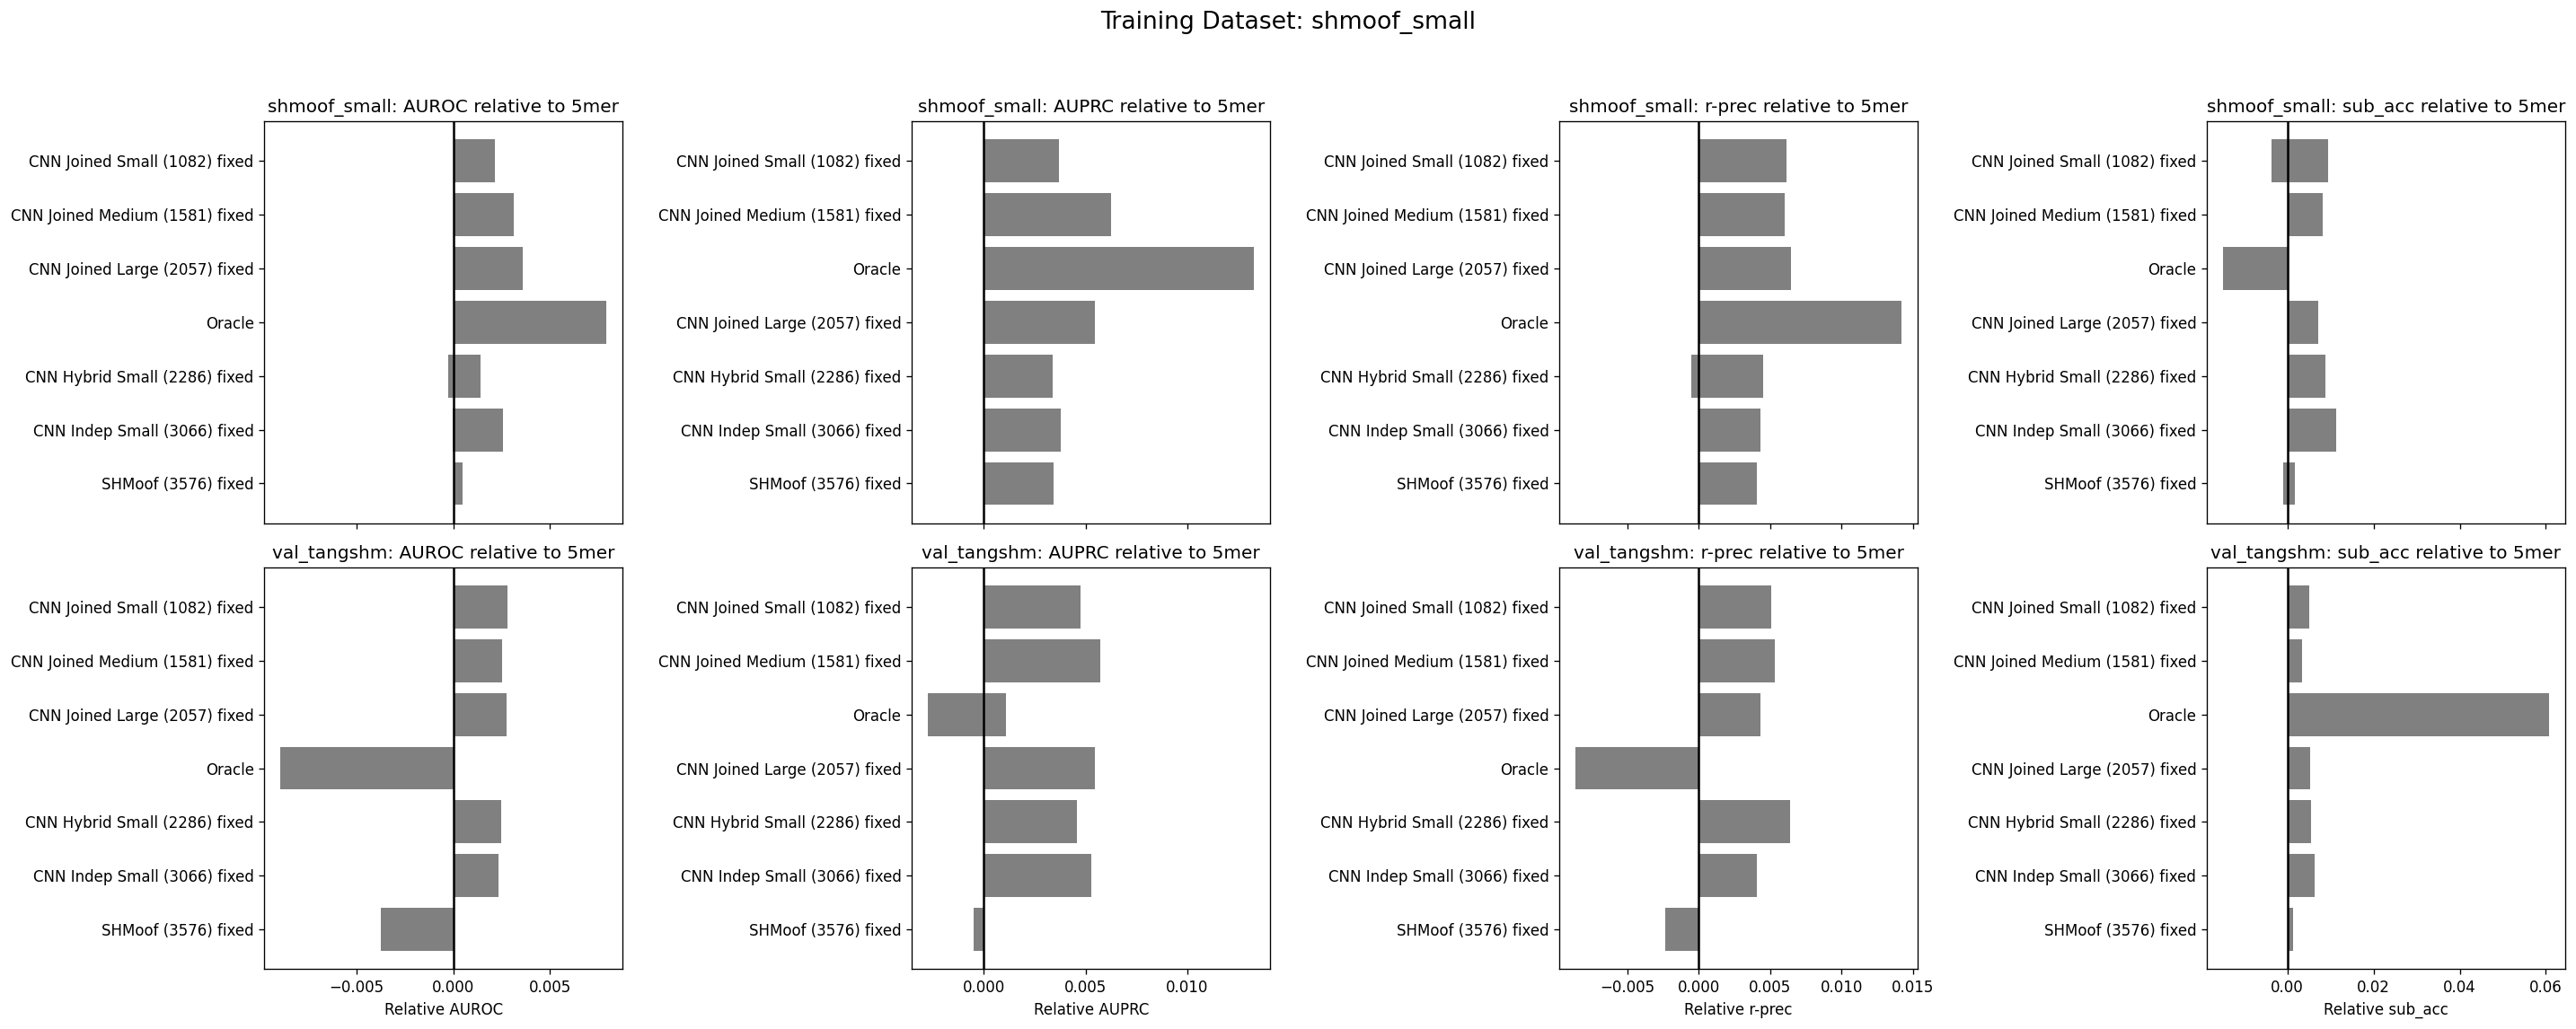

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame
# stats = ['AUROC', 'AUPRC', 'r-prec', 'mut_pos_ll', 'sub_acc', 'base_ll']
stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc']
train_datasets = df['train dataset'].unique()
test_datasets = df['test dataset'].unique()

# Setup figure parameters, transposing nrows with ncols
nrows = len(test_datasets)
ncols = len(stats)

# Loop through each training dataset to create separate figures or subplot grids
for train_dataset in train_datasets:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), sharex='col', squeeze=False)
    fig.suptitle(f'Training Dataset: {train_dataset}', fontsize=16)

    for row_idx, test_dataset in enumerate(test_datasets):
        # Filter the DataFrame for models trained on `train_dataset` and tested on `test_dataset`
        df_filtered = df[(df['train dataset'] == train_dataset) & (df['test dataset'] == test_dataset)].copy()

        # Assuming baseline model filtering remains as you defined
        baseline_values = df_filtered[df_filtered['model'].str.contains('fivemer')].iloc[0]
        
        for col_idx, stat in enumerate(stats):
            if not df_filtered.empty:
                df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
                df_filtered = df_filtered[df_filtered.model != "fivemer"]
                df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

                ax = axes[row_idx, col_idx]
                ax.barh(df_filtered['long_name'], df_filtered[stat + '_relative'], color='gray')
                ax.set_title(f"{test_dataset}: {stat} relative to 5mer")
                ax.axvline(x=0, color='k')  # Vertical line at 0
                if row_idx == nrows - 1:  # Only set x-labels for the bottom row
                    ax.set_xlabel(f'Relative {stat}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()
